# Paddle Python Trainer API使用说明

目前Paddle的PythonTrainerAPI处在一个测试阶段，很多设计都可以修改。包括接口。

## 开发周期

1. 使用Paddle的swig接口暴露出足够多支持Paddle训练的API，这个暴露级别最好在GradientMachine这个级别，可以方便用户自定义训练过程。
2. 在swig API的基础上，确定Python的用户接口是什么样子
3. 将swig API修改成C-API，进而可以多语言操控Paddle的训练

## 预期达到的效果

1. 用户可以完全使用Paddle Python的库完成训练。
  1. 训练过程中的信息，可以以强类型传递给Python端。
     * 正确率
     * cost
     * pass_id, batch_id
  2. 训练过程中的测试频率等工作，完全交由用户进行
     * 默认pass结束测试全部数据，但用户可以随意更改
  3. 用户可以非常自由的选择更新参数
     * 针对不同的数据，训练神经网络的不同部分。
       * 一组数据训练网络的左半边，另一组训练右半边
  4. 更方便的多目标学习

## Python端用户接口的封装

### 整体样例

下面以一个简单的线性回归作为用户接口的使用样例。这个线性回归是以 x和y为变量，回归一个 y=w*x+b 的方程。其中w和b预设为2和0.3。神经网络中的w和b都是学习出来的。 

首先，先import一些包。Python的训练接口复用了目前Paddle的很多逻辑。

1. 网络配置复用的是trainer_config_helpers里面的配置
2. 数据传输复用的是PyDataProvider2的格式

`from py_paddle.trainer import *`这行import了Paddle Python端的训练函数。`import py_paddle.swig_paddle as api`这行import了底层swig暴露的接口。

In [1]:
from paddle.trainer_config_helpers import *
from paddle.trainer.PyDataProvider2 import *
from py_paddle.trainer import *
import py_paddle.swig_paddle as api

In [2]:
@network(inputs={
    'x': dense_vector(1), 'y': dense_vector(1)
}, learning_rate=1e-3, batch_size=12)
def linear_network(x, y):
    y_predict = fc_layer(input=x, param_attr=ParamAttr(name='w'), size=1,
                         act=LinearActivation(), bias_attr=ParamAttr(name='b'))
    cost = regression_cost(input=y_predict, label=y)
    return cost

上面定义Paddle需要训练网络的网络结构。这个网络结构的定义使用了Python的函数。

`@network`是一个decorator，它将下面的函数变成Paddle的神经网络描述(protobuf)。其参数包括:

* inputs. 传输数据类型是一个字典，key是函数的参数名(这里就是x、y)，value是x，y对应的数据类型。这里数据类型都是dense的vector
  * 可用的数据类型参考PyDataProvider2的@provider的input_types类型
* 其余的参数是paddle的优化参数。参考`settings`

In [3]:
help(settings)  # run this line to print document of settings method.

Help on function settings in module paddle.trainer_config_helpers.optimizers:

settings(*args, **kwargs)
    Set the optimization method, learning rate, batch size, and other training
    settings. The currently supported algorithms are SGD and Async-SGD.
    
    ..  warning::
    
        Note that the 'batch_size' in PaddlePaddle is not equal to global
        training batch size. It represents the single training process's batch
        size. If you use N processes to train one model, for example use three
        GPU machines, the global batch size is N*'batch_size'.
    
    :param batch_size: batch size for one training process.
    :type batch_size: int
    :param learning_rate: learning rate for SGD
    :type learning_rate: float
    :param learning_method: The extension optimization algorithms of gradient
                            descent, such as momentum, adagrad, rmsprop, etc.
                            Note that it should be instance with base type
                    

在linear_network里面定义的就是神经网络的计算图。返回值就是优化目标。

使用decorator `@network`，我们将这个函数封装成了一个Python类。进而，我们声明一个网络描述实例`linear`。

In [4]:
linear = linear_network()

这个描述是实例里面包含了一些Paddle的计算图信息和网络输入顺序等等。下面几个block可以手动运行，展开输出。

In [5]:
help(linear_network)  # run this line to print document of linear_network

Help on class NetworkConfigImpl in module py_paddle.trainer.network:

class NetworkConfigImpl(NetworkConfig)
 |  Method resolution order:
 |      NetworkConfigImpl
 |      NetworkConfig
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |  
 |  input_order(self)
 |  
 |  input_types(self)
 |  
 |  network_graph(self)
 |  
 |  optimize_graph(self)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from NetworkConfig:
 |  
 |  provider(self, **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from NetworkConfig:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [6]:
print linear.input_types()

{'y': <paddle.trainer.PyDataProvider2.InputType object at 0x118a37908>, 'x': <paddle.trainer.PyDataProvider2.InputType object at 0x118a378c0>}


In [7]:
print linear.network_graph()  # Paddle neural network protobuf definition

type: "nn"
layers {
  name: "y"
  type: "data"
  size: 1
  active_type: ""
}
layers {
  name: "x"
  type: "data"
  size: 1
  active_type: ""
}
layers {
  name: "__fc_layer_0__"
  type: "fc"
  size: 1
  active_type: ""
  inputs {
    input_layer_name: "x"
    input_parameter_name: "w"
  }
  bias_parameter_name: "b"
}
layers {
  name: "__regression_cost_0__"
  type: "square_error"
  size: 1
  active_type: ""
  inputs {
    input_layer_name: "__fc_layer_0__"
  }
  inputs {
    input_layer_name: "y"
  }
  coeff: 1.0
}
parameters {
  name: "w"
  size: 1
  initial_mean: 0.0
  initial_std: 1.0
  dims: 1
  dims: 1
  initial_strategy: 0
  initial_smart: true
}
parameters {
  name: "b"
  size: 1
  initial_mean: 0.0
  initial_std: 1.0
  dims: 1
  dims: 1
  initial_strategy: 0
  initial_smart: true
}
input_layer_names: "y"
input_layer_names: "x"
output_layer_names: "__regression_cost_0__"
sub_models {
  name: "root"
  layer_names: "y"
  layer_names: "x"
  layer_names: "__fc_layer_0__"
  layer_name

In [8]:
configs = {
    'w': 2,
    'b': 0.3
}

进而我们设置一下线性回归的参数。`y=w*x+b`， w和b设置为2和0.3。 这个dict被dataprovider使用。

In [9]:
import random

@linear.provider()
def process(*args, **kwargs):
    for i in xrange(2000):
        x = random.random()
        yield {'x': [x], 'y': [configs['w'] * x + configs['b']]}


下一步是声明数据读取器(DataProvider)。其本身也是一个函数, `process`。

Paddle的PyDataProvider2的数据读取的主要想法是，用户只需要关注**从一个文件里**如何读取**一条数据**，然后按照一种数据格式yield出去。其他batch组合，数据shuffle等工作Paddle完成。

声明这个DataProvider的过程，也是使用一个Decorator完成。注意这个decorator实际上是**linear实例的一个函数**。

这个函数的参数和PyDataProvider2一样，第一个是settings，第二个是filename。不过这里procees函数实际上没有使用任何参数，故process中使用`*args, **kwargs`来接受任意参数。

返回值是使用yield返回。这里必须使用**字典**。

In [10]:
help(process)

Help on class DataProvider in module paddle.trainer.PyDataProvider2:

class DataProvider(__builtin__.object)
 |  Methods defined here:
 |  
 |  __init__(self, file_list, **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [11]:
runner = RunnerBuilder(network=linear).with_train_data(method=process).build()

下一步是构造一个Runner，Runner是Python Trainer API中的最基础数据类型。它具有的操作是

* 执行一个Pass。 run_one_pass。
* 增加一个Pass中的执行步骤，例如打印输出等等。

RunnerBulder是一个简单的Runner生成器。他负责将Paddle的训练流程插入到Runner的执行步骤中。

这里network传入linear对象，而训练数据的读取函数是process。调用build生成runner

关于Runner的具体说明参考其他文档，或者注释。

In [12]:
learning_result = {
    'cost': [],
    'w': [],
    'b': []
}

我们声明一个learning_result字典，来保存训练过程中的数据，三个field分别保存每个pass后的误差，w值和b值。方便我们画图。

In [13]:
with runner:
    while True:
        ctx = ContextWrapper(runner.run_one_pass())
        learning_result['cost'].append(ctx.cost())
        params = ctx.gradient_machine().getParameters()
        for param in params:
            learning_result[param.getName()].append(param.getBuf(api.PARAMETER_VALUE)[0])
        
        if abs(ctx.cost() - 0.0) < 1e-10:
            # end training.
            break

上面这个循环便是全部训练过程。

第一行with runner，是指我要使用runner这个类来进行训练了。在使用某一个runner前，必须使用with，来初始化一些数据。同时目前Paddle只支持一个进程使用一个runner(Paddle的全局变量问题)。

每一个run_one_pass()会返回一个当前的context，使用context wrapper可以更好(类型安全)，更快(TODO 可以使用Cython优化)的访问Context。

In [14]:
help(ctx)

Help on ContextWrapper in module py_paddle.trainer.base_items object:

class ContextWrapper(__builtin__.object)
 |  Strong typed wrapper to read/write context value.
 |  
 |  @TODO(yuyang18): Use Cython to implement this class, make it directly access
 |                   a C struct.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, context)
 |  
 |  batch_id(self, field_name='current_batch_id')
 |  
 |  batch_size(self, field_name='current_batch_size')
 |      :param field_name:
 |      :return:
 |      :rtype: int
 |  
 |  cost(self, field_name='current_cost')
 |      :param field_name:
 |      :return:
 |      :rtype: float
 |  
 |  get_field(self, field_name)
 |  
 |  get_field_with_type(self, field_name, tp)
 |  
 |  gradient_machine(self, field_name='gradient_machine')
 |      Get Gradient Machine
 |      :param field_name:
 |      :return:
 |      :rtype: api.GradientMachine
 |  
 |  in_args(self, field_name='in_args')
 |      :param field_name:
 |      :return:
 |      :rt

这个训练过程中，我们不指定训练次数，而是指定当误差小于1e-10的时候，我们就退出。

同时，记录下每一个pass的w和b值。

之后我们便可以使用matplotlib画图。画图的方法不在赘述。是标准的matplotlib使用

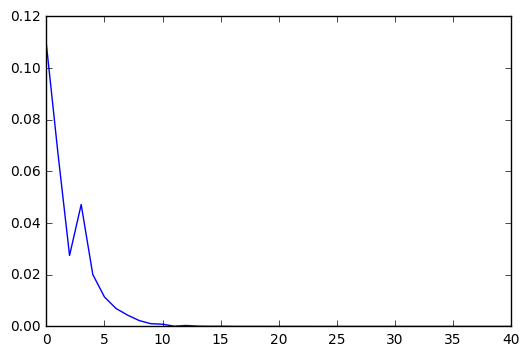

In [15]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot("cost", data=learning_result)
plt.show()


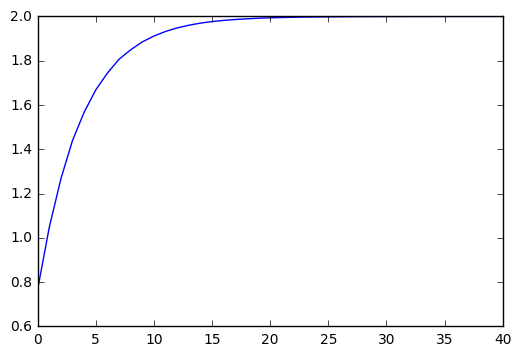

In [16]:
plt.plot("w", data=learning_result)
plt.show()


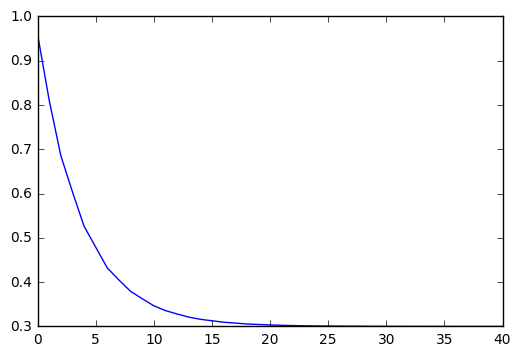

In [17]:
plt.plot("b", data=learning_result)
plt.show()


至此，一个简单的Python Trainer API使用说明写完了。